## Importimi i librarive

In [23]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle

from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from numpy import loadtxt

import matplotlib.pyplot as plt

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

## Ngarkimi i datasetit dhe përcaktimi i variablës hyrëse dhe asaj dalëse (target)

In [24]:
data = pd.read_csv("Dataseti\GrammarandProductReviews.csv")

reviews = data['reviews.text']
y = data['reviews.didPurchase']

## Numri i vlerave te kolones `reviews.didPurchase`

In [25]:
y.value_counts().to_frame().rename(columns = {'reviews.didPurchase' : 'Review Purchased'})

,Review Purchased
False,28476
True,3682


## Filtrimi i rreshtave per te cilet `reviews.didPurchase` ose `reviews.text` eshte NULL

In [26]:
data = data[data['reviews.didPurchase'].notna()]
data = data[data['reviews.text'].notna()]

## Dimensionet e datasetit pas filtrimit

In [27]:
data.shape

(32156, 25)

In [28]:
data.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,149773828.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My boyfriend and I bought this to spice things...,Not worth it,NaN,NaN,Samantha,67981934427


## Kontrollimi per vlerat NULL te kolonave `reviews.didPurchase`

In [29]:
data['reviews.didPurchase'].isnull().sum()

0

## Kontrollimi per vlerat NULL te kolonave `reviews.text`

In [30]:
data['reviews.text'].isnull().sum()

0

## Percaktimi i variables hyrese dhe asaj dalese (target)

In [31]:
reviews = data['reviews.text']
y = data['reviews.didPurchase']

## Numri i produkteve te cilat jane blere dhe numri i atyre qe nuk jane blere

In [32]:
y.value_counts()

False    28474
True      3682
Name: reviews.didPurchase, dtype: int64

## Vendosja e teksteve (reviews.text) në një listë të vetme

In [37]:
docs = []  ## <class 'list'>
for sen in reviews:
    docs.append(sen)


### Preprocesimi

In [38]:
stop_words = set(line.strip() for line in open('stopwords.txt'))
exclude = set(string.punctuation) 
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    #Remove stop words in documents
    docs = [[token for token in doc if not token in stop_words] for doc in docs]
    #Remove punctuations in documents
    docs = [[token for token in doc if not token in exclude] for doc in docs]
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 2] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs
# Perform function on our document
documents = docs_preprocessor(docs)

## Enkodimi i variables dalese - `reviews.didPurchase`

In [39]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)
dummy_y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Vendosja e fjaleve ne varg, dhe shoqerimi i seciles fjale me nje numer-indeks

In [40]:
tokenizer = Tokenizer(nb_words=16000, lower=True )

tokenizer.fit_on_texts(documents)

sequences = tokenizer.texts_to_sequences(documents)

word_index = tokenizer.word_index

print('U gjetën %s tokena unik.' % len(word_index))

# convert text to sequence of tokens and pad them to ensure equal length vectors 
x = pad_sequences(sequences, maxlen=15)

U gjetën 16023 tokena unik.


## Ndarja e të dhënave në trajnuese dhe testuese

In [15]:
seed = 20
 
x_train, x_test, y_train, y_test = train_test_split(x, encoded_y, 	train_size=0.8, random_state=seed)


Results from Decision Tree

              precision    recall  f1-score   support

           0     0.9026    0.8965    0.8995      5683
           1     0.2529    0.2657    0.2591       749

    accuracy                         0.8231      6432
   macro avg     0.5777    0.5811    0.5793      6432
weighted avg     0.8269    0.8231    0.8250      6432

DT accuracy: 0.8230721393034826


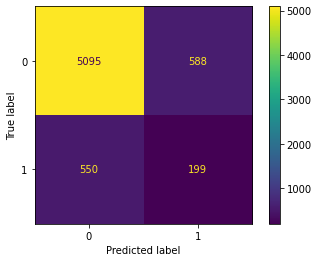

In [16]:
print("\nResults from Decision Tree\n")

clf_DT = DecisionTreeClassifier() 
 
clf_DT.fit(x_train, y_train)

accuracy=clf_DT.score(x_test, y_test)

y_pred = clf_DT.predict(x_test)

# print(confusion_matrix(y_test, y_pred))  
plot_confusion_matrix(clf_DT, x_test, y_test) 

print(classification_report(y_test, y_pred,digits=4))
   
print("DT accuracy:", accuracy)


Results from Naive Bayes

              precision    recall  f1-score   support

           0     0.9407    0.7090    0.8085      5683
           1     0.2303    0.6609    0.3416       749

    accuracy                         0.7034      6432
   macro avg     0.5855    0.6849    0.5751      6432
weighted avg     0.8580    0.7034    0.7542      6432

NB accuracy: 0.7033582089552238


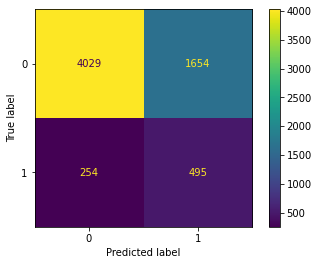

In [17]:
print("\nResults from Naive Bayes\n")

clf_NB = MultinomialNB() 
 
clf_NB.fit(x_train, y_train)

accuracy=clf_NB.score(x_test, y_test)

y_pred = clf_NB.predict(x_test)

# print(confusion_matrix(y_test, y_pred))  
plot_confusion_matrix(clf_NB, x_test, y_test) 

print(classification_report(y_test, y_pred, digits=4)) 
  
print("NB accuracy:", accuracy)



Results from Boosting

              precision    recall  f1-score   support

           0     0.8914    0.9861    0.9363      5683
           1     0.4552    0.0881    0.1477       749

    accuracy                         0.8815      6432
   macro avg     0.6733    0.5371    0.5420      6432
weighted avg     0.8406    0.8815    0.8445      6432

AdaBoost accuracy: 0.8815298507462687


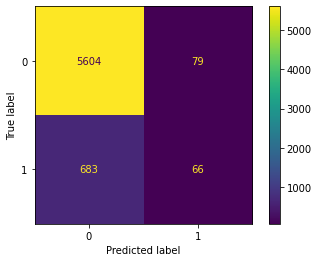

In [18]:
print("\nResults from Boosting\n")

clf_Ada = AdaBoostClassifier()
 
clf_Ada.fit(x_train, y_train)

accuracy=clf_Ada.score(x_test, y_test)

y_pred = clf_Ada.predict(x_test)

# print(confusion_matrix(y_test, y_pred))  
plot_confusion_matrix(clf_Ada, x_test, y_test) 

print(classification_report(y_test, y_pred, digits=4)) 
  
print("AdaBoost accuracy:", accuracy)


Results from Random Forest

              precision    recall  f1-score   support

           0     0.8944    0.9870    0.9384      5683
           1     0.5404    0.1162    0.1912       749

    accuracy                         0.8856      6432
   macro avg     0.7174    0.5516    0.5648      6432
weighted avg     0.8532    0.8856    0.8514      6432

Random Forest accuracy: 0.8855721393034826


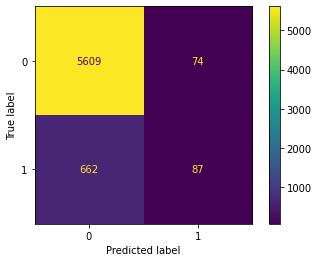

In [19]:
print("\nResults from Random Forest\n")

from sklearn.ensemble import RandomForestRegressor

clf_RF = RandomForestClassifier(max_depth=200, random_state=0)
 
clf_RF.fit(x_train, y_train)

accuracy=clf_RF.score(x_test, y_test)

y_pred = clf_RF.predict(x_test)

# print(confusion_matrix(y_test, y_pred))  
plot_confusion_matrix(clf_RF, x_test, y_test) 

print(classification_report(y_test, y_pred, digits=4)) 
  
print("Random Forest accuracy:", accuracy)

In [20]:
fjalia_prej_inputit = ["good flavor !! review. collected promotion"]
fjalia_e_procesuar = docs_preprocessor(fjalia_prej_inputit)

instance = tokenizer.texts_to_sequences(fjalia_e_procesuar)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, maxlen=15)

clf_DT.predict(instance)

array([1])

In [21]:
def prediction_string(text, alg):
    if alg == "NB":

        y_pred = clf_NB.predict(text)

        return y_pred

    elif alg == "RF":
        
        y_pred = clf_RF.predict(text)
        
        return y_pred

    elif alg == "AdaBoost":
        
        y_pred = clf_Ada.predict(text)

        return y_pred

    elif alg == "DT":
        
        y_pred = clf_DT.predict(text)
        
        return y_pred

In [22]:
print(prediction_string(instance, "DT"))

[1]
